<a href="https://colab.research.google.com/github/PatrickPrakash/LiptoSpeech/blob/main/ExtractMouth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from os import listdir
from os.path import isfile, join
from scipy import misc
import numpy as np
import sys
import os
import cv2
import dlib
import argparse
import skvideo.io
from google.colab.patches import cv2_imshow 

In [7]:
FPS = 25
FRAME_ROWS = 120
FRAME_COLS = 120
NFRAMES = 5 # size of input volume of frames
MARGIN = NFRAMES/2
COLORS = 1 # grayscale
CHANNELS = COLORS*NFRAMES
MAX_FRAMES_COUNT= 250 # corresponding to 10 seconds, 25Hz*10

In [10]:
pwd

'/content'

In [11]:
FACE_PREDICTOR_PATH = '/content/LiptoSpeech/predictor/shape_predictor_68_face_landmarks.dat'

In [17]:
!ls

id2_vcd_swwp2s.mpg  LiptoSpeech  mouth_extract	sample_data


In [32]:
def process_video():
    input_video_path = "/content/id2_vcd_swwp2s.mpg"
    cap = cv2.VideoCapture(input_video_path)
    video_fps = int(cap.get(cv2.CAP_PROP_FPS))

    assert FPS == video_fps, "video FPS is not 25 Hz"

    total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = skvideo.io.FFmpegWriter('mouth_extract/'+input_video_path.split('/')[-1]+'_lip_highlight.mp4')

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(FACE_PREDICTOR_PATH)

    activation = []
    max_counter = MAX_FRAMES_COUNT
    num_frames = min(total_num_frames,max_counter)
    counter = 0
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Required parameters for mouth extraction.
    width_crop_max = 0
    height_crop_max = 0

    temp_frames = np.zeros((num_frames,FRAME_ROWS,FRAME_COLS),dtype="uint8")
    for i in np.arange(num_frames):
        ret,frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if ret==0:
            break
        if counter > num_frames:
            break

        # Detection of the frame
        detections = detector(frame, 1)

        # 20 mark for mouth
        marks = np.zeros((2, 20))

        # All unnormalized face features.
        if len(detections) > 0:
            for k, d in enumerate(detections):

                # Shape of the face.
                shape = predictor(frame, d)

                co = 0
                # Specific for the mouth.
                for ii in range(48, 68):
                    """
                    This for loop is going over all mouth-related features.
                    X and Y coordinates are extracted and stored separately.
                    """
                    X = shape.part(ii)
                    A = (X.x, X.y)
                    marks[0, co] = X.x
                    marks[1, co] = X.y
                    co += 1

                # Get the extreme points(top-left & bottom-right)
                X_left, Y_left, X_right, Y_right = [int(np.amin(marks, axis=1)[0]), int(np.amin(marks, axis=1)[1]),
                                                    int(np.amax(marks, axis=1)[0]),
                                                    int(np.amax(marks, axis=1)[1])]

                # Find the center of the mouth.
                X_center = (X_left + X_right) / 2.0
                Y_center = (Y_left + Y_right) / 2.0

                # Make a boarder for cropping.
                border = 30
                X_left_new = X_left - border
                Y_left_new = Y_left - border
                X_right_new = X_right + border
                Y_right_new = Y_right + border

                # Width and height for cropping(before and after considering the border).
                width_new = X_right_new - X_left_new
                height_new = Y_right_new - Y_left_new
                width_current = X_right - X_left
                height_current = Y_right - Y_left

                # Determine the cropping rectangle dimensions(the main purpose is to have a fixed area).
                if width_crop_max == 0 and height_crop_max == 0:
                    width_crop_max = width_new
                    height_crop_max = height_new
                else:
                    width_crop_max += 1.5 * np.maximum(width_current - width_crop_max, 0)
                    height_crop_max += 1.5 * np.maximum(height_current - height_crop_max, 0)

                # # # Uncomment if the lip area is desired to be rectangular # # # #
                #########################################################
                # Find the cropping points(top-left and bottom-right).
                X_left_crop = int(X_center - width_crop_max / 2.0)
                X_right_crop = int(X_center + width_crop_max / 2.0)
                Y_left_crop = int(Y_center - height_crop_max / 2.0)
                Y_right_crop = int(Y_center + height_crop_max / 2.0)
                #########################################################

                if X_left_crop >= 0 and Y_left_crop >= 0 and X_right_crop < w and Y_right_crop < h:
                    mouth = frame[Y_left_crop:Y_right_crop, X_left_crop:X_right_crop, :]

                    # Save the mouth area.
                    mouth_gray = cv2.cvtColor(mouth, cv2.COLOR_RGB2GRAY)
                    mouth_gray = cv2.resize(mouth_gray,(FRAME_COLS,FRAME_ROWS))
                    temp_frames[i*COLORS:i*COLORS+COLORS,:,:] = mouth_gray
                    cv2.imwrite(mouth_destination_path + '/' + 'frame' + '_' + str(counter) + '.png', mouth_gray)

                    print("The cropped mouth is detected ...")
                    activation.append(1)
                else:
                    cv2.putText(frame, 'The full mouth is not detectable. ', (30, 30), font, 1, (0, 255, 255), 2)
                    temp_frames[i*COLORS:i*COLORS+COLORS,:,:] = np.zeros((FRAME_ROWS,FRAME_COLS),dtype="uint8")
                    print("The full mouth is not detectable....")
                    activation.append(0)
        else:
            cv2.putText(frame, 'Mouth is not detectable. ', (30, 30), font, 1, (0, 0, 255), 2)
            print("Mouth is not detectable. ...")
            temp_frames[i*COLORS:i*COLORS+COLORS,:,:] = np.zeros((FRAME_ROWS,FRAME_COLS),dtype="uint8")
            activation.append(0)

        if activation[counter] == 1:
            # Demonstration of face.
            cv2.rectangle(frame, (X_left_crop, Y_left_crop), (X_right_crop, Y_right_crop), (0, 255, 0), 2)


            cv2_imshow(frame)
        
        print('frame number {} of {}'.format(counter,num_frames))

        # write the output frame to file
        print("writing frame {} with activation {}".format(counter + 1,activation[counter]))
        writer.writeFrame(frame)
        counter += 1
    writer.close()
    temp_frames = temp_frames.astype(np.uint8)
    print('temp_frames shape: ', temp_frames.shape)
    skvideo.io.vwrite('mouth_extract/'+input_video_path.split('/')[-1]+'_lip_cropped.mp4', temp_frames)
    vidctr = 0
    SAMPLE_LEN = int(num_frames-2*MARGIN)
    visual_cube = np.zeros((SAMPLE_LEN,CHANNELS,FRAME_ROWS,FRAME_COLS), dtype="uint8")
    for i in np.arange(MARGIN,SAMPLE_LEN+MARGIN):
    		visual_cube[vidctr,:,:,:] = temp_frames[int(COLORS*(i-MARGIN)):int(COLORS*(i+MARGIN)),:,:]
    		vidctr = vidctr+1
    visual_cube = visual_cube.transpose(0, 2, 3, 1)
    print('visual_cube shape: {}   , sequence_length = {} '.format(visual_cube.shape,visual_cube.shape[0]))

The cropped mouth is detected ...


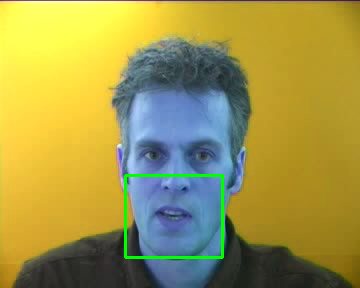

frame number 0 of 75
writing frame 1 with activation 1
The cropped mouth is detected ...


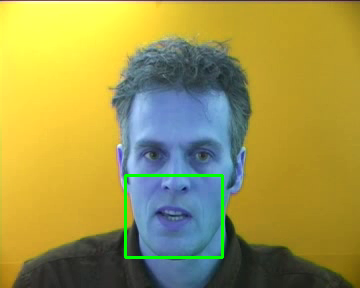

frame number 1 of 75
writing frame 2 with activation 1
The cropped mouth is detected ...


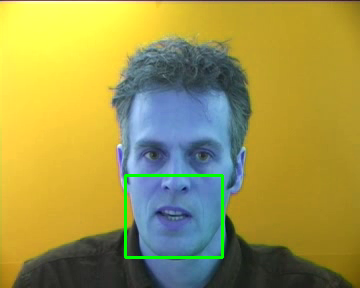

frame number 2 of 75
writing frame 3 with activation 1
The cropped mouth is detected ...


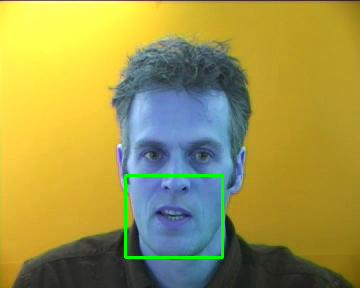

frame number 3 of 75
writing frame 4 with activation 1
The cropped mouth is detected ...


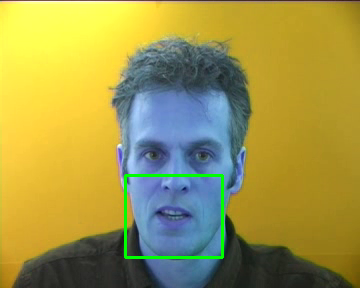

frame number 4 of 75
writing frame 5 with activation 1
The cropped mouth is detected ...


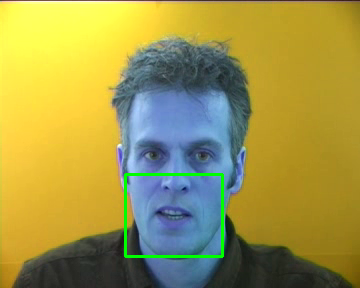

frame number 5 of 75
writing frame 6 with activation 1
The cropped mouth is detected ...


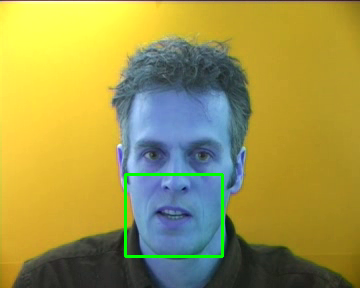

frame number 6 of 75
writing frame 7 with activation 1
The cropped mouth is detected ...


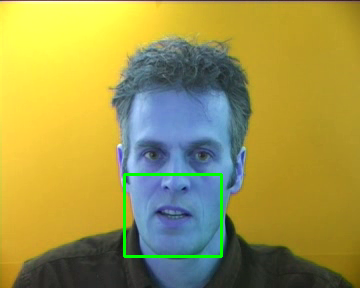

frame number 7 of 75
writing frame 8 with activation 1
The cropped mouth is detected ...


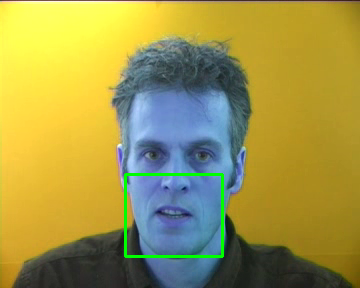

frame number 8 of 75
writing frame 9 with activation 1
The cropped mouth is detected ...


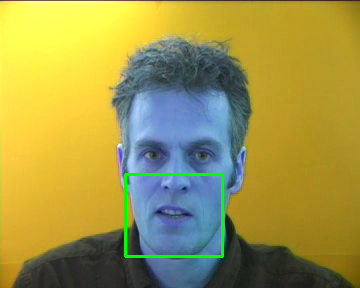

frame number 9 of 75
writing frame 10 with activation 1
The cropped mouth is detected ...


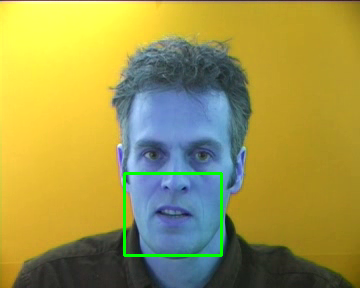

frame number 10 of 75
writing frame 11 with activation 1
The cropped mouth is detected ...


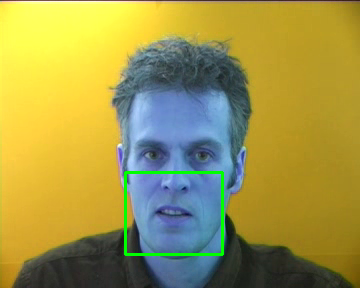

frame number 11 of 75
writing frame 12 with activation 1
The cropped mouth is detected ...


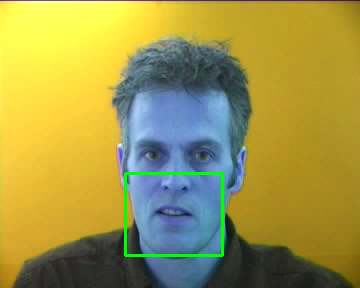

frame number 12 of 75
writing frame 13 with activation 1
The cropped mouth is detected ...


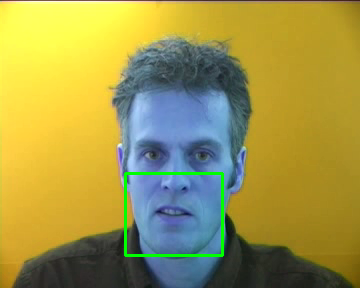

frame number 13 of 75
writing frame 14 with activation 1
The cropped mouth is detected ...


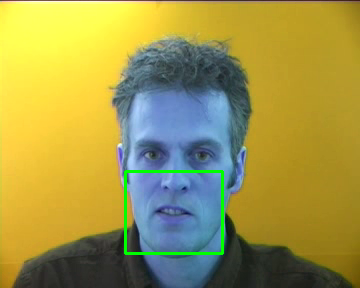

frame number 14 of 75
writing frame 15 with activation 1
The cropped mouth is detected ...


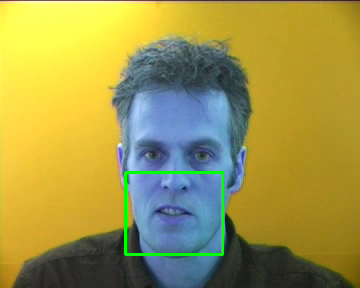

frame number 15 of 75
writing frame 16 with activation 1
The cropped mouth is detected ...


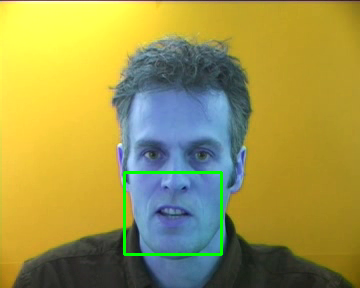

frame number 16 of 75
writing frame 17 with activation 1
The cropped mouth is detected ...


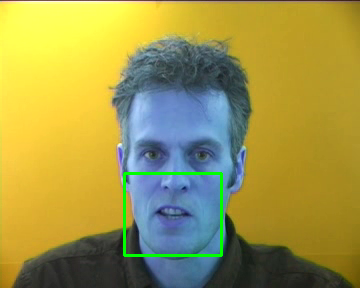

frame number 17 of 75
writing frame 18 with activation 1
The cropped mouth is detected ...


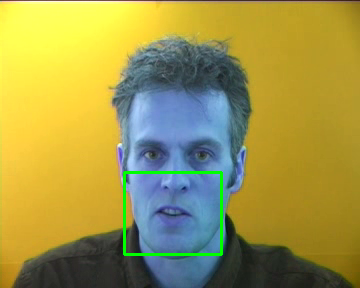

frame number 18 of 75
writing frame 19 with activation 1
The cropped mouth is detected ...


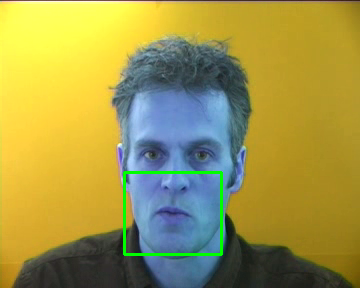

frame number 19 of 75
writing frame 20 with activation 1
The cropped mouth is detected ...


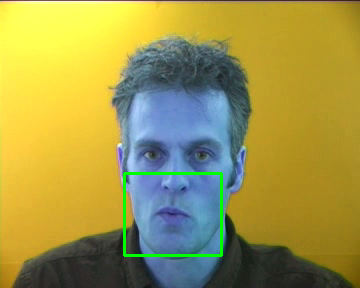

frame number 20 of 75
writing frame 21 with activation 1
The cropped mouth is detected ...


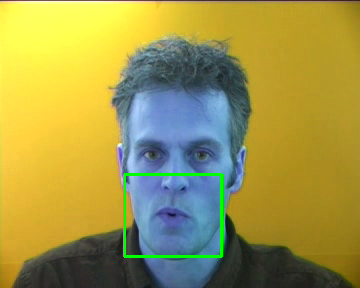

frame number 21 of 75
writing frame 22 with activation 1
The cropped mouth is detected ...


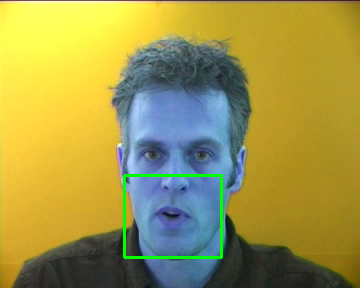

frame number 22 of 75
writing frame 23 with activation 1
The cropped mouth is detected ...


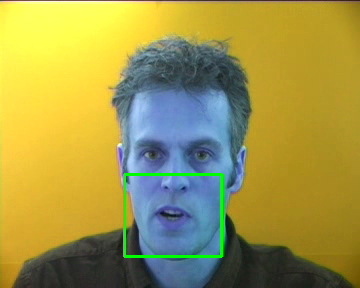

frame number 23 of 75
writing frame 24 with activation 1
The cropped mouth is detected ...


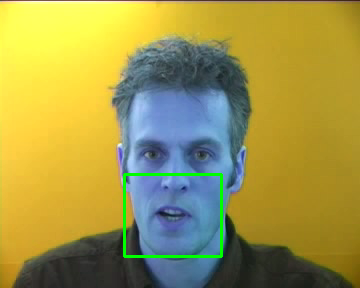

frame number 24 of 75
writing frame 25 with activation 1
The cropped mouth is detected ...


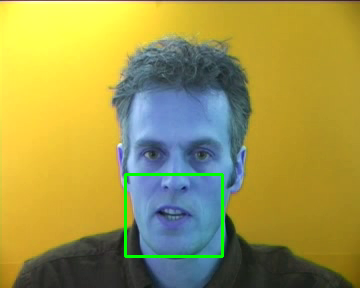

frame number 25 of 75
writing frame 26 with activation 1
The cropped mouth is detected ...


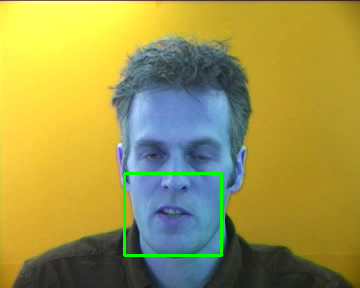

frame number 26 of 75
writing frame 27 with activation 1
The cropped mouth is detected ...


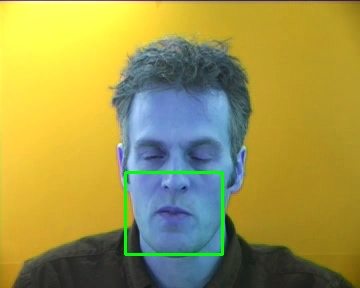

frame number 27 of 75
writing frame 28 with activation 1
The cropped mouth is detected ...


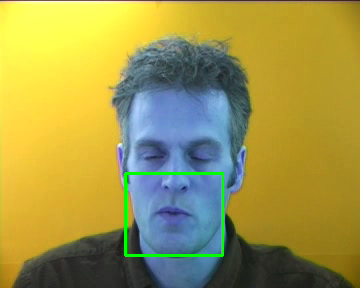

frame number 28 of 75
writing frame 29 with activation 1
The cropped mouth is detected ...


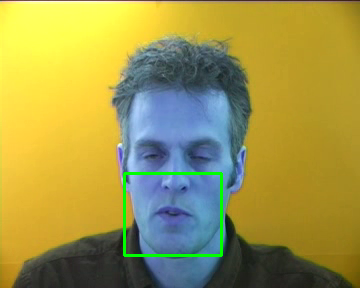

frame number 29 of 75
writing frame 30 with activation 1
The cropped mouth is detected ...


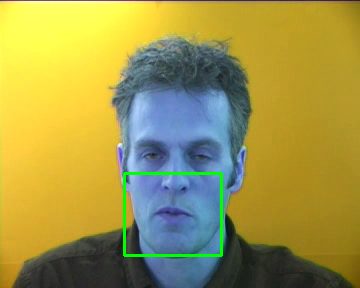

frame number 30 of 75
writing frame 31 with activation 1
The cropped mouth is detected ...


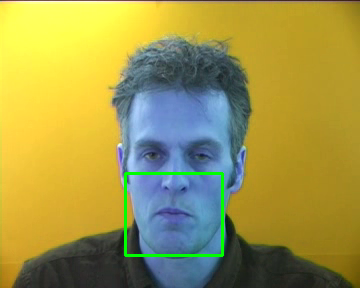

frame number 31 of 75
writing frame 32 with activation 1
The cropped mouth is detected ...


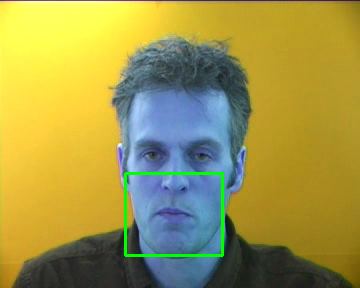

frame number 32 of 75
writing frame 33 with activation 1
The cropped mouth is detected ...


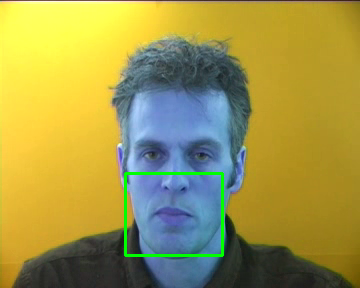

frame number 33 of 75
writing frame 34 with activation 1
The cropped mouth is detected ...


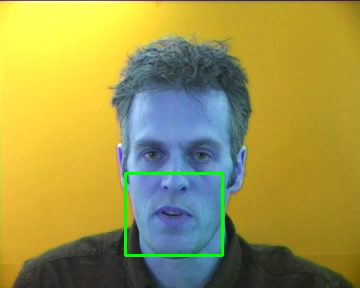

frame number 34 of 75
writing frame 35 with activation 1
The cropped mouth is detected ...


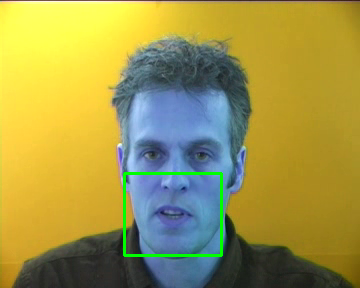

frame number 35 of 75
writing frame 36 with activation 1
The cropped mouth is detected ...


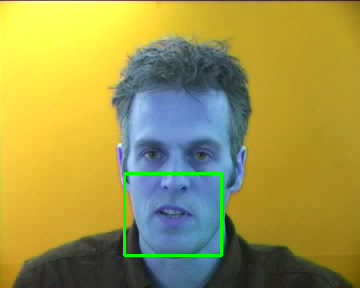

frame number 36 of 75
writing frame 37 with activation 1
The cropped mouth is detected ...


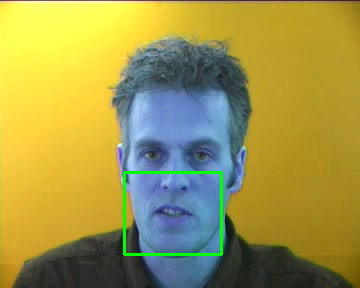

frame number 37 of 75
writing frame 38 with activation 1
The cropped mouth is detected ...


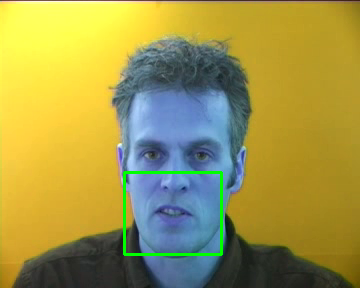

frame number 38 of 75
writing frame 39 with activation 1
The cropped mouth is detected ...


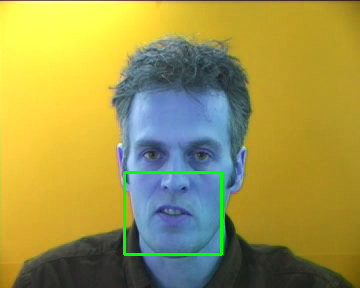

frame number 39 of 75
writing frame 40 with activation 1
The cropped mouth is detected ...


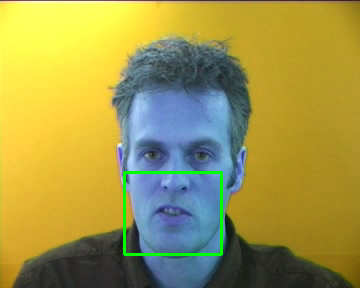

frame number 40 of 75
writing frame 41 with activation 1
The cropped mouth is detected ...


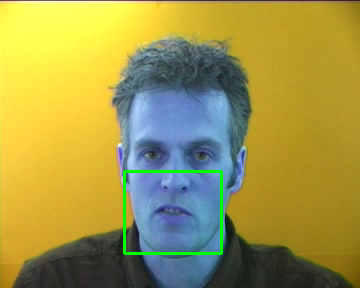

frame number 41 of 75
writing frame 42 with activation 1
The cropped mouth is detected ...


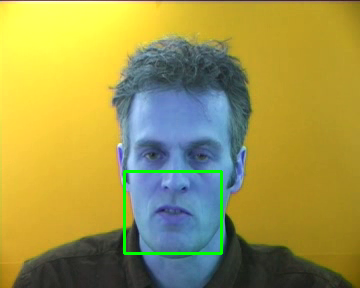

frame number 42 of 75
writing frame 43 with activation 1
The cropped mouth is detected ...


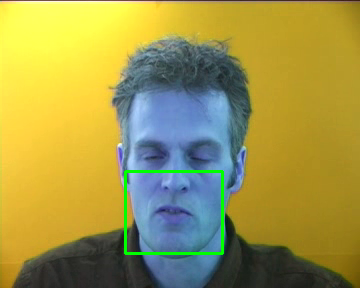

frame number 43 of 75
writing frame 44 with activation 1
The cropped mouth is detected ...


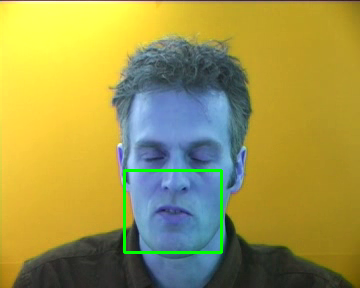

frame number 44 of 75
writing frame 45 with activation 1
The cropped mouth is detected ...


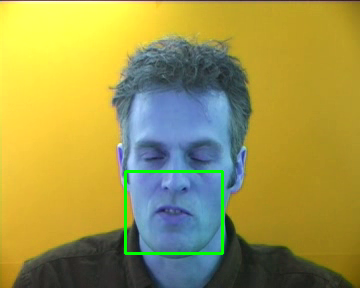

frame number 45 of 75
writing frame 46 with activation 1
The cropped mouth is detected ...


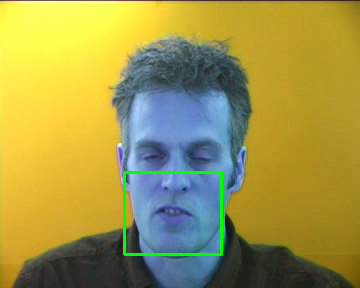

frame number 46 of 75
writing frame 47 with activation 1
The cropped mouth is detected ...


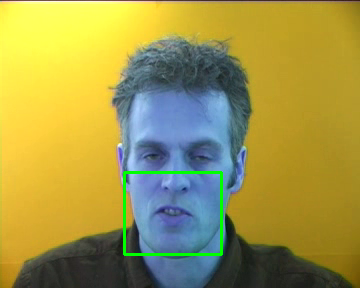

frame number 47 of 75
writing frame 48 with activation 1
The cropped mouth is detected ...


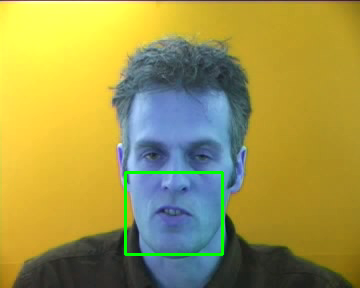

frame number 48 of 75
writing frame 49 with activation 1
The cropped mouth is detected ...


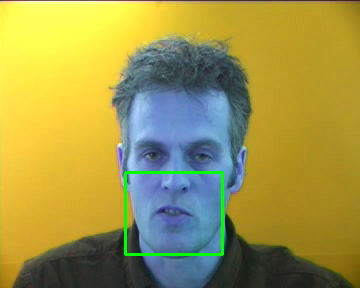

frame number 49 of 75
writing frame 50 with activation 1
The cropped mouth is detected ...


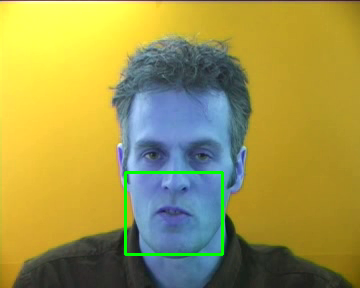

frame number 50 of 75
writing frame 51 with activation 1
The cropped mouth is detected ...


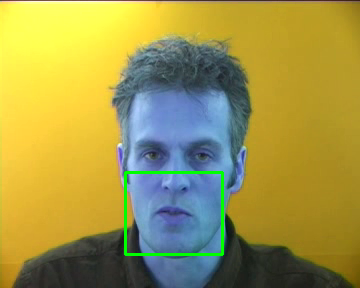

frame number 51 of 75
writing frame 52 with activation 1
The cropped mouth is detected ...


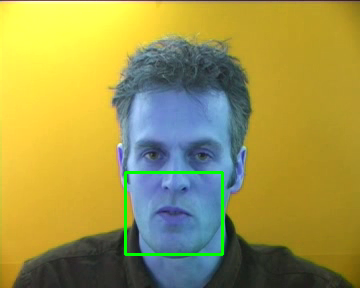

frame number 52 of 75
writing frame 53 with activation 1
The cropped mouth is detected ...


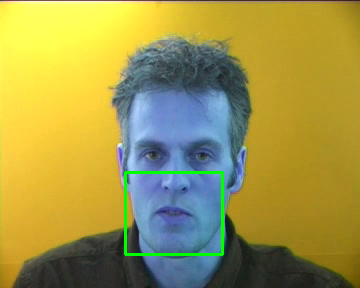

frame number 53 of 75
writing frame 54 with activation 1
The cropped mouth is detected ...


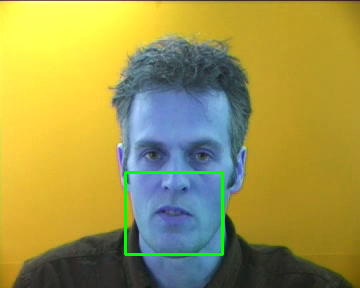

frame number 54 of 75
writing frame 55 with activation 1
The cropped mouth is detected ...


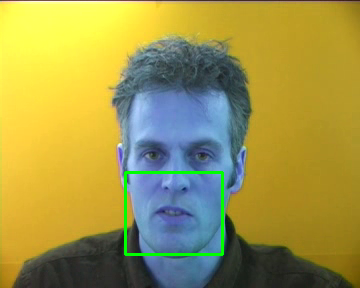

frame number 55 of 75
writing frame 56 with activation 1
The cropped mouth is detected ...


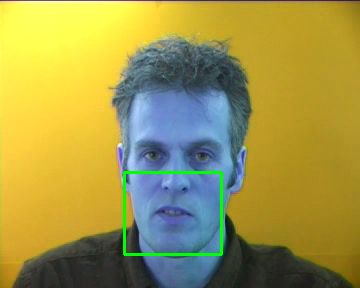

frame number 56 of 75
writing frame 57 with activation 1
The cropped mouth is detected ...


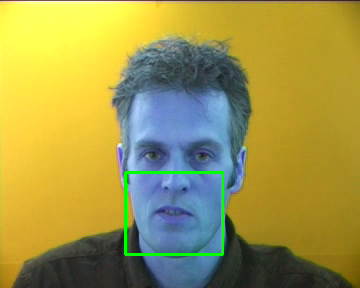

frame number 57 of 75
writing frame 58 with activation 1
The cropped mouth is detected ...


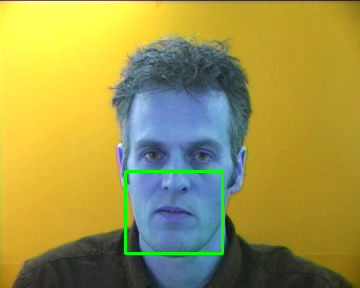

frame number 58 of 75
writing frame 59 with activation 1
The cropped mouth is detected ...


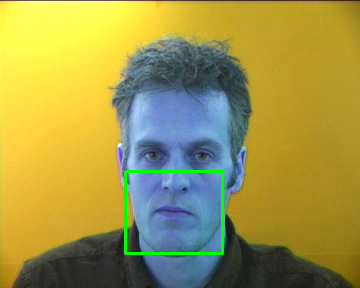

frame number 59 of 75
writing frame 60 with activation 1
The cropped mouth is detected ...


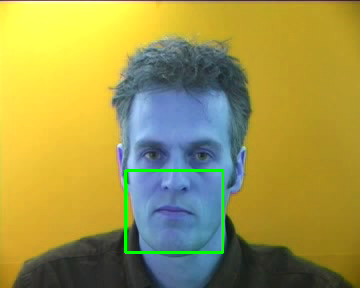

frame number 60 of 75
writing frame 61 with activation 1
The cropped mouth is detected ...


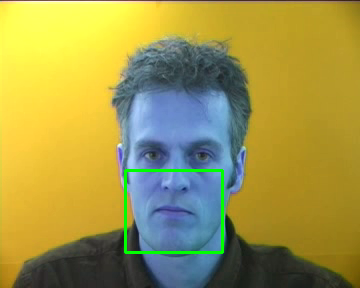

frame number 61 of 75
writing frame 62 with activation 1
The cropped mouth is detected ...


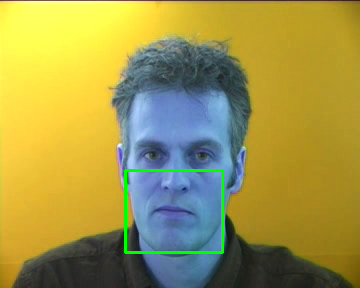

frame number 62 of 75
writing frame 63 with activation 1
The cropped mouth is detected ...


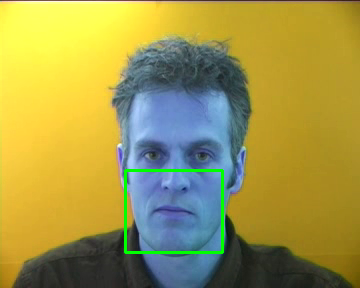

frame number 63 of 75
writing frame 64 with activation 1
The cropped mouth is detected ...


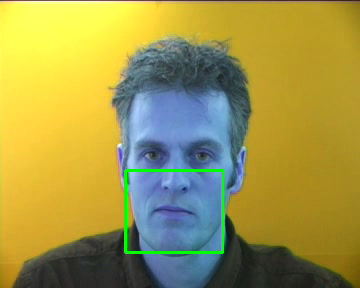

frame number 64 of 75
writing frame 65 with activation 1
The cropped mouth is detected ...


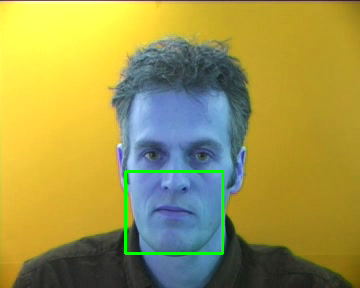

frame number 65 of 75
writing frame 66 with activation 1
The cropped mouth is detected ...


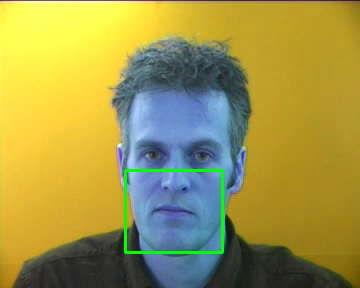

frame number 66 of 75
writing frame 67 with activation 1
The cropped mouth is detected ...


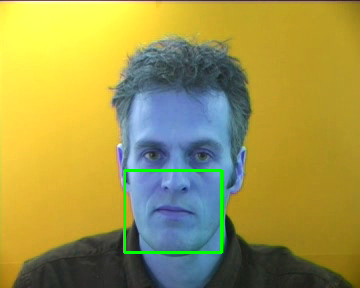

frame number 67 of 75
writing frame 68 with activation 1
The cropped mouth is detected ...


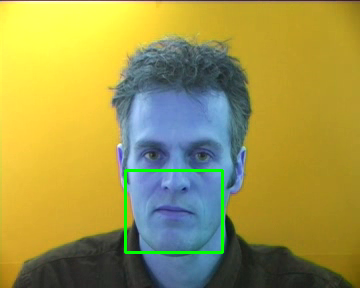

frame number 68 of 75
writing frame 69 with activation 1
The cropped mouth is detected ...


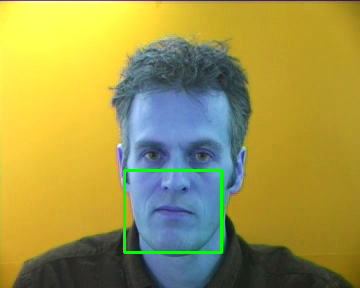

frame number 69 of 75
writing frame 70 with activation 1
The cropped mouth is detected ...


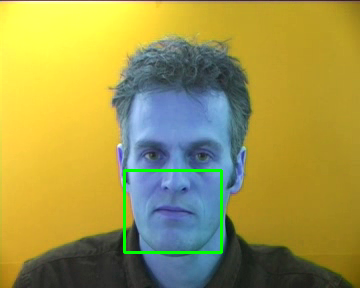

frame number 70 of 75
writing frame 71 with activation 1
The cropped mouth is detected ...


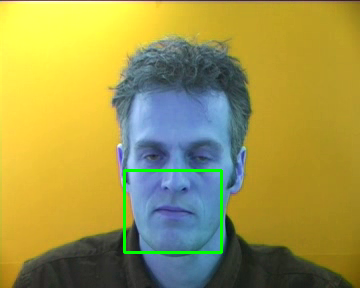

frame number 71 of 75
writing frame 72 with activation 1
The cropped mouth is detected ...


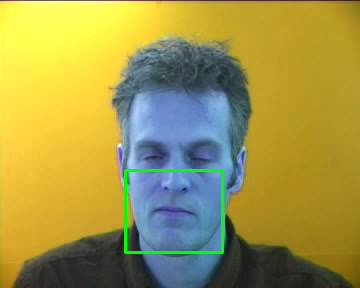

frame number 72 of 75
writing frame 73 with activation 1
The cropped mouth is detected ...


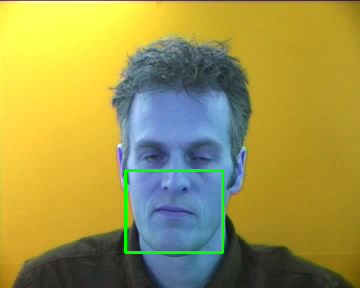

frame number 73 of 75
writing frame 74 with activation 1
The cropped mouth is detected ...


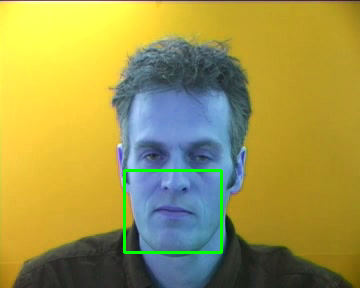

frame number 74 of 75
writing frame 75 with activation 1
temp_frames shape:  (75, 120, 120)
visual_cube shape: (70, 120, 120, 5)   , sequence_length = 70 


In [33]:
process_video()